<a href="https://colab.research.google.com/github/salama4ai/AI-project/blob/main/TensorFlow_model_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is for preprocessing the data and implementing the model using Pytorch library

In [1]:
# importing the libraries
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
import joblib
import pickle

import tensorflow as tf
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [2]:
# This function to be able to reproduce the same numbers in the future, by fixing
# the algorithms parameters that lead to generate the same random numbers

# printing pytorch version as this point may affect the reproducability if diffrent pytorch version used
print(f'using version {tf.__version__}')


# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, tensorflow

    This function to be able to reproduce the same numbers in the future, by fixing
    the algorithms parameters that lead to generate the same random numbers

    Args:
        seed (int): Seed to be used.
    """

    #
    os.environ['PYTHONHASHSEED']=str(seed)

    # set seed for python random numbers.Set `python` pseudo-random generator at a fixed value
    random.seed(seed)

    # set seed for numpy random numbers. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed)

    #GLOBAL SEED:- set seed for tensorflow random numbers.  Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed)

    # tf gpu fix seed, please `pip install tensorflow-determinism` first
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


    # sets seeds for keras
    tf.keras.utils.set_random_seed(seed)

    # forcing tensorflow to use single thread since multiple threads are potential source of un-reproducibility
    # Configure a new global `tensorflow` session
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

    # # if if speed is less important than reproducibility then un-comment this line, as it will reduce the calculations-speed significantly but will leads to more robust reproducibility
    # tf.config.experimental.enable_op_determinism()

seed=71
set_random_seed(seed=seed)

using version 2.13.0


In [3]:
# read the csv data file
x = pd.read_csv("/content/drive/MyDrive/Mabrains-project/Mabrains-data/mabrains.csv")

In [4]:
# show the first 5 rows
x.head()

,vds,L(um),W(um),vgs,vsb,corner,id(uA)
0,-0.45,8.0,0.84,0.0,0.0,tt,0.034866
1,-0.40,8.0,0.84,0.0,0.0,tt,0.009451
2,-0.35,8.0,0.84,0.0,0.0,tt,0.002331
3,-0.30,8.0,0.84,0.0,0.0,tt,0.000532
4,-0.25,8.0,0.84,0.0,0.0,tt,0.000111


# Preprocessing & Feature-Engineering

1- i will convert corner column into one hot encoded columns

2- i will write the equation of id as a code and use it to calculate id

3- also as i showed in the EDA note book that 'Temperature' and 'drain_length(um)' columns can be deleted safely as each of them contains only a single unique repeated value, thus the entropy in each of them are zero and the information that they will contripute to the model are also zeros, so removing them will not represent any losing, yet by including them in the model we increase curse-of-dimentionality and make it's harded for the model to extract the underlying knowledge from the other columns.

In [5]:
# separate the output(or label or target) column from the features(input) columns, where 'x' the feature columns, and 'y' is the target column
y = x.pop("id(uA)")

# split the train and test sets and the coresponding labels
xtrain_unprocessed, xtest_unprocessed, ytrain, ytest = train_test_split(x, y, test_size=0.21, random_state=seed, shuffle=True)

# apply the needed transformations over the determined columns
col_trans1 = make_column_transformer(("passthrough", ['vds', 'vgs', 'vsb', 'W(um)', 'L(um)']),
                                    (OneHotEncoder(handle_unknown="infrequent_if_exist"), ['corner']),
                                     remainder="drop",
                                     n_jobs=-1)

# apply the needed transformations over the training data
xtrain = col_trans1.fit_transform(xtrain_unprocessed)

# apply the needed transformations over the testing data
xtest = col_trans1.transform(xtest_unprocessed)

In [6]:
#compine the features and the corresponding labels into one object
train_set = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))

#compine the features and the corresponding labels into one object
test_set = tf.data.Dataset.from_tensor_slices((xtest, ytest))

In [7]:
# initializing R2Score function
r2score = tf.keras.metrics.R2Score()

#initializing mean-square-error function
Mean_Square_Error = tf.keras.losses.MeanSquaredError()

# initializing the mean_absolute_percentage_error function
mean_absolute_percentage_error = tf.keras.losses.MeanAbsolutePercentageError()

# evaluate the performance using the R2Score and mean-square-error pytorch functions
def evaluate_model(model, data_loader):
    '''this function is to evaluate the performance of the model using R2Score and mean-square-error pytorch functions'''

    # initialize the labels and preds and transfering them to device(cpu or gpu)
    labels = np.array([], dtype=np.float32)
    predictions = np.array([], dtype=np.float32)

    # starting the loop over data
    for features, label in data_loader:

        # concatenate all the labels
        labels = tf.concat(values=[labels, label.numpy()], axis=0)

        # get the model predictions of the given data and flatten them
        preds = tf.reshape(model(features, training=False), -1).numpy()

        # concatenate all the predictions
        predictions = tf.concat(values=[preds, predictions], axis=0)

    # calculate the r2score
    r2score_evaluation = r2score(tf.reshape(labels, (-1, 1)), tf.reshape(predictions, (-1, 1)))

    # calculate mean square error loss
    mean_square_error_evaluation = Mean_Square_Error(labels, predictions)

    # calculate the mean_absolute_percentage_error_evaluation
    mean_absolute_percentage_error_evaluation = mean_absolute_percentage_error(labels, predictions)

    # evaluation metric
    model_evaluations = np.array([r2score_evaluation, mean_square_error_evaluation, mean_absolute_percentage_error_evaluation])

    # return the r2score_accuracy result
    return model_evaluations

i will inject the equation to the model in the last layers why? to increase the effect of the equation over the final model output as it added to the last model layers

In [8]:
class network(tf.keras.Model):
    '''create the structure of the model'''

    def __init__(self, in_features=6, out_features=1):
        '''like a class constructor function or initialization'''

        super().__init__()
        self.mc = tf.Variable(tf.random.normal([1], seed=seed, dtype=tf.float32), name="mc")
        self.vt = tf.Variable(tf.random.normal([1], seed=seed, dtype=tf.float32), name="vt")
        # the fully connected layers
        self.fc1 = tf.keras.layers.Dense(units=30, input_shape=(in_features,), activation='tanh')
        self.fc2 = tf.keras.layers.Dense(units=3, activation='relu')
        self.fc3 = tf.keras.layers.Dense(units=33#, input_shape=(4,)
        , activation='tanh')
        self.fc4 = tf.keras.layers.Dense(units=15, activation='leaky_relu')
        self.fc5 = tf.keras.layers.Dense(units=out_features, activation='relu')

        # initialize the model parameters(weights, bias)

    def call(self, features):
        '''this the forward path of the model'''

        # caution:- if you change the order of feature columns you need to adjust these order also
        self.vds = features[:, 0]
        self.vgs = features[:, 1]
        self.vsb = features[:, 2]
        self.W = features[:, 3]
        self.L = features[:, 4]
        self.corner = features[:, 5:10]

        self.k = self.vds/((self.vgs-self.vt)*(self.vgs-self.vt))
        # multiply the equation by 1000 as the id output is in milli.
        equation = 1000*(self.W/self.L)*np.square(self.vds)*((self.vgs-self.vt)-self.vds/2)*self.mc*self.k
        inpt = tf.concat([tf.reshape(self.vsb, (-1, 1)), self.corner], axis=1)

        # i used different activation functions to enable the model to select the output without limitation of any activation function
        out = self.fc1(inpt)
        out = self.fc2(out)
        out = tf.concat([tf.reshape(equation, (-1, 1)), out], axis=1)
        # here i will inject the equation to the model, why? to increase the effect of the equation over the
        # final output as it added to the last model layers
        out = self.fc3(out)
        out = self.fc4(out)
        # i used relu at the last layer as the id current is only positive
        out = self.fc5(out)
        return out

In [9]:
 # define the training function.
def train_model(num_epochs, data_loader):

    # set the number of batches to be the length of 'data_loader'
    num_batches = len(data_loader)

    # print the hyperparameters informations that the model going to train based on.
    print(f"""batch_size = {batch_size} \n starting learning rate = {learning_rate} \n number of epochs = {num_epochs}\
    \n number of batches = {num_batches} \n model = {model}, \n criterion={criterion}, \n optimizer={optimizer}""")

    # initialize lists to save the training and testing validation progress to be able to plot the results later
    evaluations_progress = np.empty(shape=(num_epochs, 2, 3))

    # start the epochs loop
    for epoch in range(num_epochs):

        # printing out the time which the model starts, to be able to calculate the minuts it take
        start_time = time.time()

        # initialize progress function that display the progress of the training.
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)

        # starting the training loop for each epoch
        for batch_idx, (features, labels) in progress:


            with tf.GradientTape() as tape:

                # calculate the predictions.
                predictions = model(features, training=True)

                # calculate the loss.
                loss = criterion(labels, predictions)

                # back propagation calculations
                grads = tape.gradient(loss, model.trainable_variables)

                # optimization step
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # determine the information to be showed while training progress and show it
            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss:0.4f}")
            progress.set_postfix()

        # calculate the training evaluations
        train_evaluations = evaluate_model(model, data_loader=train_loader)

        # calculate the test evaluations
        test_evaluations = evaluate_model(model, data_loader=test_loader)

        # printing the important information about the training progress
        print(f"after {1+epoch} epoch, \ntrain-data evaluation:- r2score = {test_evaluations[0]:.5f}, MSE = {test_evaluations[1]:.2f}, MAPE = {test_evaluations[2]:.5f}%\
        \ntest-data evaluation:-  r2score = {test_evaluations[0]:.5f}, MSE = {test_evaluations[1]:.2f}, MAPE = {test_evaluations[2]:.5f}%\
        time_elapsed = {((time.time()-start_time)/60):.1f} minuts. \n","-"*119)

        # add the training evaluations to a list to be able to visulaize the over all progress after the training completed
        evaluations_progress[epoch, 0, :] = train_evaluations

        # the same but for the test evaluations
        evaluations_progress[epoch, 1, :] = test_evaluations

    # # print the model structure
    print(model.summary())

    # return test_eval_progress and train_eval_progress after the training completed
    return evaluations_progress

In [10]:
# from this cell you can adjust/tune almost all the hyper paremeters,
# except the model structure which can be adjusted from the previous cell

# initializing the model and convert it to device(gpu or cpu)
model = network()

# the Learning Rate hyperparameter
learning_rate = 0.0005

# loss initializing
# criterion = tf.keras.metrics.R2Score()
# criterion = tf.keras.losses.MeanSquaredError()
criterion = tf.keras.losses.MeanAbsolutePercentageError()

#learning-rate schedular initialization
# i used values here to elimiate this function effect, as i found i don't need it now, and i didn't remove it totally
# to be able to call it again just by modify the factor and patience values without change any other part of the code
learning_rate_schedular = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, decay_steps=10000, decay_rate=0.9, staircase=False, name='learning_rate_schedular')

# optimizer initializing
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedular)
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_schedular)


# determine number of calculations
num_epochs = 17

# set the batch size
batch_size = 4096

# create the train_loader object
train_loader = train_set.batch(batch_size).shuffle(seed=seed, buffer_size=512)

# create the test_loader object
test_loader = test_set.batch(batch_size)

# lets check the valaidation before training
# starting_test_eval = evaluate_model(model, data_loader=test_loader)

# call the training function
evaluations_progress = train_model(num_epochs, data_loader=train_loader)

batch_size = 4096 
 starting learning rate = 0.0005 
 number of epochs = 17   
 number of batches = 169 
 model = <__main__.network object at 0x7c4cabdb3a30>, 
 criterion=<keras.src.losses.MeanAbsolutePercentageError object at 0x7c4cabd3d510>, 
 optimizer=<keras.src.optimizers.adam.Adam object at 0x7c4caa49b820>


epoch [1/17], loss=90.8533: 100%|██████████| 169/169 [00:23<00:00,  7.17it/s]


after 1 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.5 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [2/17], loss=91.6991: 100%|██████████| 169/169 [00:12<00:00, 13.91it/s]


after 2 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.3 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [3/17], loss=91.6953: 100%|██████████| 169/169 [00:12<00:00, 13.79it/s]


after 3 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.3 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [4/17], loss=91.2934: 100%|██████████| 169/169 [00:14<00:00, 11.47it/s]


after 4 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.4 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [5/17], loss=91.5616: 100%|██████████| 169/169 [00:13<00:00, 12.66it/s]


after 5 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.3 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [6/17], loss=91.0640: 100%|██████████| 169/169 [00:16<00:00, 10.39it/s]


after 6 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.4 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [7/17], loss=92.1687: 100%|██████████| 169/169 [00:22<00:00,  7.41it/s]


after 7 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.6 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [8/17], loss=90.9838: 100%|██████████| 169/169 [00:19<00:00,  8.74it/s]


after 8 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.5 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [9/17], loss=91.3926: 100%|██████████| 169/169 [00:16<00:00, 10.47it/s]


after 9 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.4 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [10/17], loss=91.7024: 100%|██████████| 169/169 [00:38<00:00,  4.43it/s]


after 10 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.8 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [11/17], loss=91.9517: 100%|██████████| 169/169 [00:18<00:00,  9.15it/s]


after 11 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.4 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [12/17], loss=92.0065: 100%|██████████| 169/169 [00:34<00:00,  4.96it/s]


after 12 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.7 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [13/17], loss=91.8491: 100%|██████████| 169/169 [00:30<00:00,  5.56it/s]


after 13 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.6 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [14/17], loss=91.9029: 100%|██████████| 169/169 [00:11<00:00, 14.92it/s]


after 14 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.3 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [15/17], loss=91.1836: 100%|██████████| 169/169 [00:16<00:00, 10.23it/s]


after 15 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.3 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [16/17], loss=91.6194: 100%|██████████| 169/169 [00:14<00:00, 11.89it/s]


after 16 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.3 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [17/17], loss=91.3477: 100%|██████████| 169/169 [00:13<00:00, 12.31it/s]


after 17 epoch, 
train-data evaluation:- r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       
test-data evaluation:-  r2score = -0.07628, MSE = 1613368.50, MAPE = 91.81876       time_elapsed = 0.4 minuts. 
 -----------------------------------------------------------------------------------------------------------------------
Model: "network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  210       
                                                                 
 dense_1 (Dense)             multiple                  93        
                                                                 
 dense_2 (Dense)             multiple                  165       
                                                                 
 dense_3 (Dense)             multiple                  510       
                                                      

- Note:- the mean absolute percentage error in tensorflow is multiplied by 100, i.e it's percentage value not a number as the case in pytorch

why i print maximum accuracy the model reached? as sometimes the model reach to a very good accuracy then it's accuracy degraded, but the point is as long as the model can reach to that good accuracy then i'm close to optimum hyperparameters and to decide if i need to change the hyperparameters with small scale or large scale.

In [11]:
# printing the maximum training accuracy and maximum testing accuracy the model reached
print(f"maximun R2Score training evaluation={(max(evaluations_progress[:, 0, 0])):.5f}\
\nmaximun R2Score test evaluation={(max(evaluations_progress[:, 0, 0])):.5f}\
\nminimun MSE training evaluation={(min(evaluations_progress[:, 0, 1]))}\
\nminimun MSE test evaluation={(min(evaluations_progress[:, 0, 1]))}\
\nmaximun MAPE training evaluation={(min(evaluations_progress[:, 0, 2])):.5f}\
\nmaximun MAPE test evaluation={(min(evaluations_progress[:, 0, 2])):.5f}")


maximun R2Score training evaluation=-0.07617
maximun R2Score test evaluation=-0.07617
minimun MSE training evaluation=1631831.25
minimun MSE test evaluation=1631831.25
maximun MAPE training evaluation=91.78150
maximun MAPE test evaluation=91.78150


### plot the overall training and testing accuracy progress

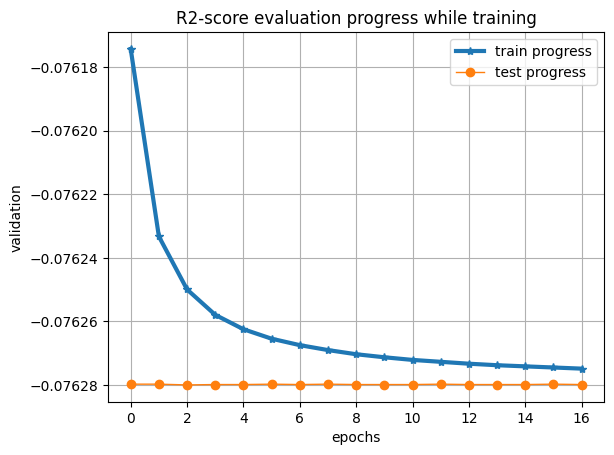

In [12]:
def plot_evaluation(train_progress, test_progress, title):
    '''function to plot the progress of training and testing data'''

    # convert the train accuracy list into numpy array.
    train_line_val = np.array([val for val in train_progress])
    # convert the train accuracy list into numpy array.
    test_line_val = np.array([val for val in test_progress])

    # plot the progress of training accuracy over epochs.
    train_progress, = plt.plot((range(len(train_line_val))), train_line_val, label="train progress", marker="*", linewidth=3)
    # plot the progress of testing accuracy over epochs.
    test_progress, = plt.plot((range(len(test_line_val))), test_line_val, label="test progress", marker="o", linewidth=1)

    # set the legend parameters.
    plt.legend(loc="best", handles=[train_progress, test_progress])
    # write the figure title.
    plt.title(title)
    # write the label of x axis.
    plt.xlabel("epochs")
    # write the label of y axis.
    plt.ylabel("validation")
    # add grid to the figure
    plt.grid(which='major')
    # to show the figure and remove any unwanted appered words
    plt.show()

plot_evaluation(evaluations_progress[:, 0, 0], evaluations_progress[:, 1, 0], 'R2-score evaluation progress while training')

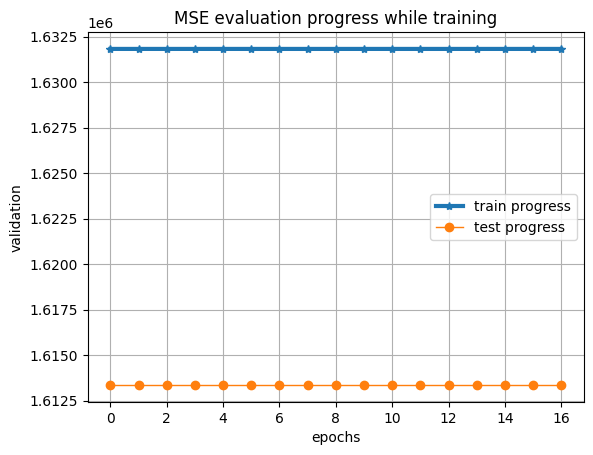

In [13]:
plot_evaluation(evaluations_progress[:, 0, 1], evaluations_progress[:, 1, 1], 'MSE evaluation progress while training')

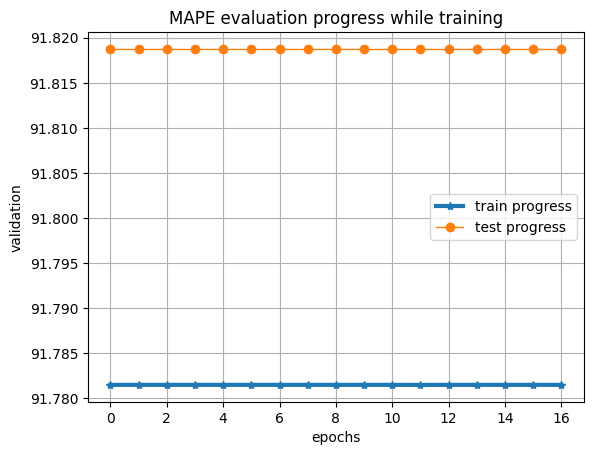

In [14]:
plot_evaluation(evaluations_progress[:, 0, 2], evaluations_progress[:, 1, 2], 'MAPE evaluation progress while training')

In [ ]:
# # to change to this directory
# %cd /content/drive/MyDrive/Mabrains-project/Mabrains-data
# # path to the saving file
# PATH = '/content/drive/MyDrive/Mabrains-project/Mabrains-data/finalized_pytorch_model2.sav'
# # Fetch the Keras session and save the model
# # The signature definition is defined by the input and output tensors,
# # and stored with the default serving key
# import tempfile
# MODEL_DIR = tempfile.gettempdir()
# print(MODEL_DIR)
# version = 1
# export_path = os.path.join(MODEL_DIR, str(version))
# print('export_path = {}\n'.format(export_path))
# tf.keras.models.save_model(model, export_path, overwrite=True, include_optimizer=True,
#                            save_format=None, signatures=None, options=None)
# print('\nSaved model:')
# !ls -l {export_path}







# # # #save the trained model to disk
# filename = 'finalized_pytorch_model.sav'
# joblib.dump(model, filename)
# # # # to load the model from disk
# loaded_model = joblib.load(filename)



# # # another way to save the trained model
# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))
# # # # to load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

/content/drive/MyDrive/Mabrains-project/Mabrains-data
/tmp
export_path = /tmp/1



NotImplementedError: ignored

### make the preprocessing steps on the test data


In [15]:
# apply the needed transformations over testing data.
xtest = col_trans1.transform(xtest_unprocessed)

# compine features and the corresponding labels in an object.
test_set = tf.data.Dataset.from_tensor_slices((xtest, ytest))

# split the test data into batches to be eaisly to deal with.
# create the test_loader object
test_loader = test_set.batch(batch_size)

In [16]:
test_eval = evaluate_model(model, data_loader=test_loader)
test_eval

array([-7.6284647e-02,  1.6133685e+06,  9.1818764e+01], dtype=float32)

### This Notebook written at Oct-2023 by Ahmad salama
- salama4ai@gmail.com
- www.linkedin.com/in/salama4ai